In [478]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import tensorflow as tf
import seaborn as sns

In [479]:
df = pd.read_csv('../3OEC_current_flow.csv')

df["O2_avg"] = df[["O2_S1", "O2_S2", "O2_S3"]].mean(axis=1)

In [480]:
from datetime import datetime, timedelta

start_time_11 = datetime(2017, 7, 11, 14, 0, 0)
end_time_11 = datetime(2017, 7, 12, 8, 0, 0)

start_time_13 = datetime(2017, 7, 13, 11, 0, 0)
end_time_13 = datetime(2017, 7, 14, 6, 0, 0)

start_time_15 = datetime(2017, 7, 15, 10, 0, 0)
end_time_15 = datetime(2017, 7, 16, 6, 0, 0)

start_time_16 = datetime(2017, 7, 16, 16, 0, 0)
end_time_16 = datetime(2017, 7, 17, 6, 0, 0)

deployments = {
    "3oec_2017_7_11_12": {"start": start_time_11, "end": end_time_11},
    "3oec_2017_7_13_14": {"start": start_time_13, "end": end_time_13},
    "3oec_2017_7_15_16": {"start": start_time_15, "end": end_time_15},
    "3oec_2017_7_16_17": {"start": start_time_16, "end": end_time_16}
}

date_ranges = []

for deployment_name, deployment_info in deployments.items():
    start_time = deployment_info["start"]
    end_time = deployment_info["end"]
    if deployment_name == "3oec_2017_7_13_14":
        start_time -= timedelta(seconds=0.125)
    print(start_time)

    # Calculate total seconds and number of measurements
    total_seconds = (end_time - start_time).total_seconds() + 0.125
    num_measurements = int(total_seconds * 8)

    # Create DatetimeIndex for the deployment
    date_range = pd.date_range(start=start_time, periods=num_measurements, freq=f'{1000/8}ms')
    print(date_range[0], date_range[-1])
    print(len(date_range))
    date_ranges.append(pd.Series(date_range))

# Concatenate all DatetimeIndexes
complete_index = pd.concat(date_ranges)

# Set the complete index to your DataFrame
df.index = complete_index

2017-07-11 14:00:00
2017-07-11 14:00:00 2017-07-12 08:00:00
518401
2017-07-13 10:59:59.875000
2017-07-13 10:59:59.875000 2017-07-14 06:00:00
547202
2017-07-15 10:00:00
2017-07-15 10:00:00 2017-07-16 06:00:00
576001
2017-07-16 16:00:00
2017-07-16 16:00:00 2017-07-17 06:00:00
403201


In [481]:
df.tail()

,deployment,t,t_increase,Vx,Vy,Vz,P,O2_S1,O2_S2,O2_S3,O2_avg
2017-07-17 05:59:59.500,3oec_2017_7_16_17,29.99987,50399.500,5.199,3.971,-0.747,82.820,245.689662,246.163399,247.119851,246.324304
2017-07-17 05:59:59.625,3oec_2017_7_16_17,29.99991,50399.625,7.785,4.487,-1.312,83.002,246.618662,245.778399,247.198851,246.531971
2017-07-17 05:59:59.750,3oec_2017_7_16_17,29.99994,50399.750,5.016,5.753,-0.937,82.895,247.084663,245.932399,246.413851,246.476971
2017-07-17 05:59:59.875,3oec_2017_7_16_17,29.99998,50399.875,5.304,2.982,-0.464,83.022,246.541663,246.548399,246.255851,246.448637
2017-07-17 06:00:00.000,3oec_2017_7_16_17,30.00001,50400.000,7.644,4.818,-1.115,82.723,245.880174,246.290942,247.116146,246.429087


In [482]:
# drop deployment column and resample
df_resampled = df.drop(columns=['deployment']).resample('5min').mean()

In [483]:
first_piece = df_resampled["2017-07-11":"2017-07-12 06:00:00"]
second_piece = df_resampled["2017-07-13 12:00:00":"2017-07-14 06:00:00"]
third_piece = df_resampled["2017-07-15 12:00:00":"2017-07-16 6:00:00"]
fourth_piece = df_resampled["2017-07-16 16:00:00":"2017-07-17"]

In [484]:
len(first_piece)

193

In [485]:
first_piece['timestamp'] = first_piece.index

/tmp/ipykernel_5754/2324523629.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_piece['timestamp'] = first_piece.index


In [486]:
# Split the data into train, val, test (70-20-10)

column_indices = {name: i for i, name in enumerate(first_piece.columns)}
n = len(first_piece)
train_df =first_piece[0:int(n*0.7)]
val_df = first_piece[int(n*0.7):int(n*0.9)]
test_df = first_piece[int(n*0.9):]


In [487]:
# Normalize the data (each partition separately)
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

/tmp/ipykernel_5754/3996967401.py:5: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  train_df = (train_df - train_mean) / train_std
/tmp/ipykernel_5754/3996967401.py:6: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  val_df = (val_df - train_mean) / train_std
/tmp/ipykernel_5754/3996967401.py:7: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  test_df = (test_df - train_mean) / train_std


/tmp/ipykernel_5754/2532475428.py:2: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  df_std = (first_piece - train_mean) / train_std
/tmp/ipykernel_5754/2532475428.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(first_piece.keys(), rotation=90)


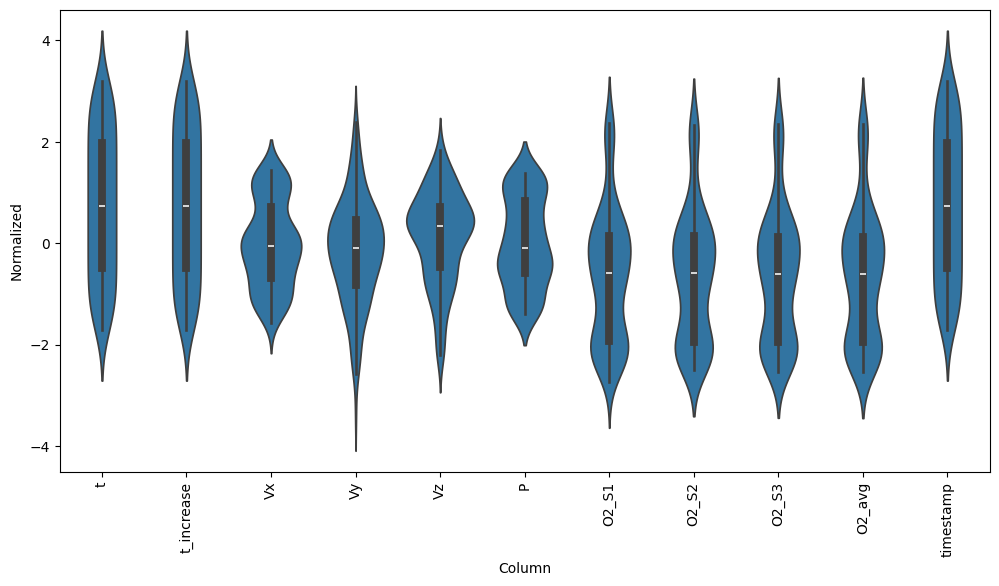

In [488]:
# Plot histogram
df_std = (first_piece - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(first_piece.keys(), rotation=90)

In [489]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                 train_df=train_df, val_df=val_df, test_df=test_df,
                 label_columns=None):
        self.train_df = train_df
        self.val_df = val_df

        self.test_df = test_df


        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
            return '\n'.join([
                f'Total window size : {self.total_window_size}',
                f'Input indices: {self.input_indices}',
                f'Label indices: {self.label_indices}',
                f'Label column name(s): {self.label_columns}'
            ])

In [490]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['O2_avg'])

In [491]:
print(w1)

Total window size : 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['O2_avg']


In [492]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['O2_avg'])
w2

Total window size : 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['O2_avg']

In [493]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack([labels[:, :, self.column_indices[name]] for name in self.label_columns],
                          axis=-1)
        
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window

In [494]:
len(train_df)

135

In [495]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[45:45+w2.total_window_size]),
                           np.array(train_df[90:90+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 11)
Inputs shape: (3, 6, 11)
Labels shape: (3, 1, 1)


In [496]:
w2.example = example_inputs, example_labels

In [515]:
# Now let's visualize the split window
def plot(self, model=None, plot_col='O2_avg', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12,8))
    plot_col_index = self.column_indices[plot_col]
    timestamp_col_index = self.column_indices['timestamp']
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(inputs[n, :, timestamp_col_index], inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)
        
        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index
        
        if label_col_index is None:
            continue

        plt.scatter(labels[n, :, timestamp_col_index], labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                        marker='X', edgecolors='k', label='Predictions',
                        c='#ff7f0e', s=64)
        
        if n == 0:
            plt.legend()
        
    plt.xlabel('Time [5min intervals]')

WindowGenerator.plot = plot

# def plot(self, model=None, plot_col='O2_avg', max_subplots=3):
#     inputs, labels = self.example
#     plt.figure(figsize=(12, 8))
    
#     plot_col_index = self.column_indices[plot_col]
#     max_n = min(max_subplots, len(inputs))

#     for n in range(max_n):
#         plt.subplot(max_n, 1, n + 1)
#         plt.ylabel(f'{plot_col} [normed]')
        
#         # Plot inputs using timestamps instead of indices
#         plt.plot(self.train_timestamps, inputs[n, :, plot_col_index],
#                  label='Inputs', marker='.', zorder=-10)
        
#         if self.label_columns:
#             label_col_index = self.label_columns_indices.get(plot_col, None)
#         else:
#             label_col_index = plot_col_index
        
#         if label_col_index is None:
#             continue

#         # Scatter plot labels using timestamps
#         plt.scatter(label_time_stamps, labels[n, :, label_col_index],
#                     edgecolors='k', label='Labels', c='#2ca02c', s=64)
        
#         if model is not None:
#             predictions = model(inputs)
#             # label_time_stamps = self.test_df.index[self.label_indices]
            
#             # Scatter plot predictions using timestamps
#             plt.scatter(label_time_stamps, predictions[n, :, label_col_index],
#                         marker='X', edgecolors='k', label='Predictions',
#                         c='#ff7f0e', s=64)
        
#         if n == 0:
#             plt.legend()
    
#     plt.xlabel('Time')
#     plt.xticks(rotation=45)  # Rotate timestamps for better readability
#     plt.tight_layout()

# Assign the function to the class
# WindowGenerator.plot = plot


2025-02-05 21:04:23.485636: W tensorflow/core/framework/op_kernel.cc:1840] OP_REQUIRES failed at strided_slice_op.cc:111 : INVALID_ARGUMENT: slice index 10 of dimension 2 out of bounds.


InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:GPU:0}} slice index 10 of dimension 2 out of bounds. [Op:StridedSlice] name: strided_slice/

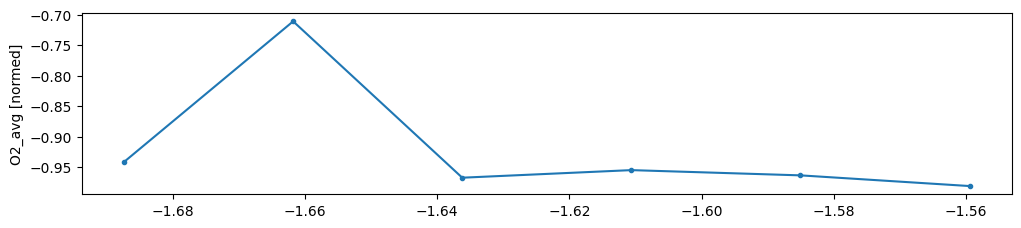

In [516]:
w2.plot()

In [499]:
# Now make a dataset using tf.data.Datasets
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=8
    )

    ds = ds.map(self.split_window)
    return ds

WindowGenerator.make_dataset = make_dataset

In [500]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of 'inputs, labels' for plotting"""
    result = getattr(self, '_example', None)
    if result is None:
        # No example btach was found, so get one from the '.train' dataset
        result = next(iter(self.train))
        # And cache it for the next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [501]:
# Each element is an (inputs, label) pair.
w2.train.element_spec

(TensorSpec(shape=(None, 6, 11), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [502]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (8, 6, 11)
Labels shape (batch, time, features): (8, 1, 1)


In [503]:
# Single step models
# Just playing around

# first create a single step window
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['O2_avg']
)
single_step_window

Total window size : 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['O2_avg']

In [504]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (8, 1, 11)
Labels shape (batch, time, features): (8, 1, 1)


In [505]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [506]:
baseline = Baseline(label_index=column_indices['O2_avg'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val, return_dict=True)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0, return_dict=True)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0031 - mean_absolute_error: 0.0442


In [507]:
wide_window = WindowGenerator(
    input_width=12, label_width=12, shift=1,
    label_columns=['O2_avg'])

wide_window

Total window size : 13
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12]
Label column name(s): ['O2_avg']

In [508]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (8, 12, 11)
Output shape: (8, 12, 1)


TypeError: Only integers, slices (`:`), ellipsis (`...`), tf.newaxis (`None`) and scalar tf.int32/tf.int64 tensors are valid indices, got 'timestamps'

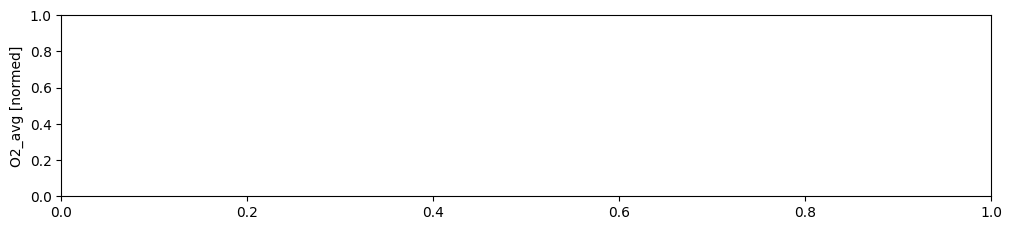

In [509]:
wide_window.plot(baseline)

In [347]:
# Now let's try LSTM
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(8, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (8, 12, 10)
Output shape: (8, 12, 1)


In [349]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [350]:
import IPython
import IPython.display

In [ ]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val, return_dict=True)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0, return_dict=True)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4277 - mean_absolute_error: 1.1391


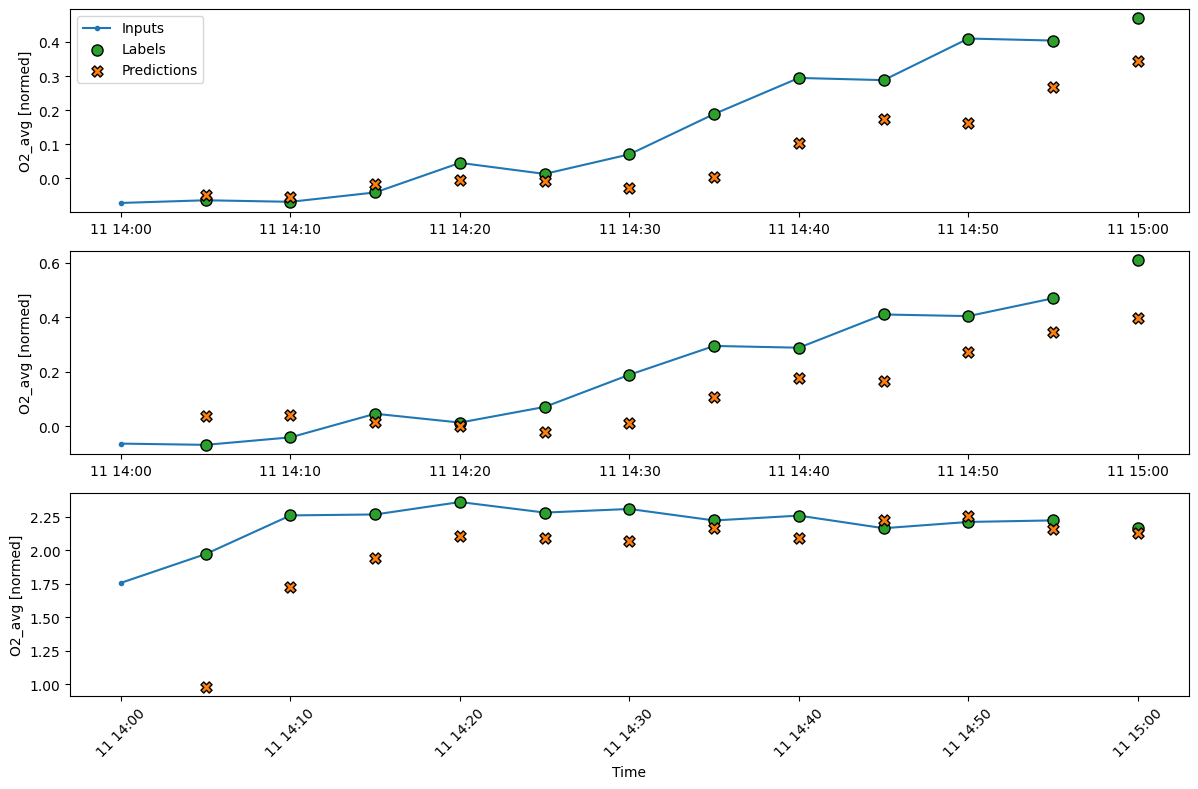

In [ ]:
wide_window.plot(lstm_model)

In [358]:
wide_window.train_df

,t,t_increase,Vx,Vy,Vz,P,O2_S1,O2_S2,O2_S3,O2_avg
2017-07-11 14:00:00,-1.712888,-1.712888,1.343698,2.383158,1.055606,0.394439,-1.035695,-1.028203,-1.097441,-1.054471
2017-07-11 14:05:00,-1.687323,-1.687323,1.378617,2.181116,1.148158,0.338188,-0.914337,-0.927522,-0.980972,-0.941558
2017-07-11 14:10:00,-1.661757,-1.661757,1.298134,2.305541,1.339606,0.277127,-0.754254,-0.751964,-0.623879,-0.710445
2017-07-11 14:15:00,-1.636192,-1.636192,1.451212,1.301064,0.422215,0.210684,-0.931415,-1.009896,-0.959430,-0.967509
2017-07-11 14:20:00,-1.610626,-1.610626,1.435985,0.822516,0.609829,0.144431,-0.954527,-0.961208,-0.947614,-0.955053
...,...,...,...,...,...,...,...,...,...,...
2017-07-12 00:50:00,1.610626,1.610626,-0.687881,1.659669,1.097692,1.184394,-1.616929,-1.604233,-1.611321,-1.611856
2017-07-12 00:55:00,1.636192,1.636192,-0.508705,1.471748,0.770507,1.171052,-1.642320,-1.635036,-1.666721,-1.649085
2017-07-12 01:00:00,1.661757,1.661757,-0.418949,1.277842,1.310038,1.144139,-1.670141,-1.681362,-1.710507,-1.688419
2017-07-12 01:05:00,1.687323,1.687323,-0.702526,1.344126,0.229915,1.115928,-1.668991,-1.681467,-1.668728,-1.674122


In [285]:
wide_window.test_df

,t,t_increase,Vx,Vy,Vz,P,O2_S1,O2_S2,O2_S3,O2_avg
2017-07-12 04:25:00,2.709943,2.709943,0.327022,-2.511008,-0.041445,-0.437089,-2.078592,-2.216434,-2.193731,-2.164280
2017-07-12 04:30:00,2.735508,2.735508,0.287042,-1.149088,0.249024,-0.457398,-2.219449,-2.190892,-2.222162,-2.212252
2017-07-12 04:35:00,2.761074,2.761074,0.004244,-2.277522,-0.273562,-0.484121,-2.146970,-2.185790,-2.165203,-2.167357
2017-07-12 04:40:00,2.786639,2.786639,0.015883,-1.685134,-0.407546,-0.494237,-2.225869,-2.223900,-2.200061,-2.218014
2017-07-12 04:45:00,2.812205,2.812205,0.171513,-1.248058,0.575436,-0.501471,-2.242410,-2.269247,-2.270729,-2.262233
2017-07-12 04:50:00,2.837770,2.837770,0.077137,-1.051019,0.195770,-0.512905,-2.348405,-2.304620,-2.294614,-2.317353
2017-07-12 04:55:00,2.863336,2.863336,0.256357,-1.325539,0.818584,-0.529740,-2.288055,-2.313656,-2.308454,-2.304851
2017-07-12 05:00:00,2.888901,2.888901,0.279844,-0.039799,1.833816,-0.537757,-2.296005,-2.347930,-2.355156,-2.334514
2017-07-12 05:05:00,2.914467,2.914467,0.245192,-0.252452,1.034644,-0.533977,-2.389844,-2.376771,-2.385724,-2.385634
2017-07-12 05:10:00,2.940032,2.940032,0.175271,-0.315072,1.025504,-0.545621,-2.420174,-2.390260,-2.359901,-2.391625


In [359]:
print(wide_window)

Total window size : 13
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12]
Label column name(s): ['O2_avg']
